In [5]:
"""
Module to train the GNN model. All config data must have been added to /src/config.ini file prior
to executing this script. A model.dat file will be created in the first run, and automatically 
loaded again in the following runs.
"""

from data import load_csv_to_df, sample_df 
from graph import create_hetero_graph
from model import GNN, run_model_for_graphs_list 
import torch
import configparser   # 파라미터 정리를 위해 
from sklearn.utils import shuffle #data 셔플링
from torch_geometric.loader import DataLoader #데이터Loader
import numpy as np
import matplotlib.pyplot as plt



config = configparser.ConfigParser()
config.read("./config.ini")


['./config.ini']

In [9]:

# Training 데이터 Load
df = load_csv_to_df(
    config["PARAMETERS"]["DataFolderPath"] + config["PARAMETERS"]["TrainFile"])

# 데이터 셔플
df = shuffle(df)
df.reset_index(inplace=True)


# 데이터 Sampling
# df = sample_df(df, sample_rate=float(
#     config["PARAMETERS"]["TrainSampleRate"]))


n_nodes = int(config["PARAMETERS"]["NumberOfNodes"]) #node 수
total = len(df) #전체 dataset 길이

#그래프 생성
graphs = []

for i in range(int(total/n_nodes)): 
    initial = i*n_nodes
    final = (i+1)*n_nodes
    temp = df[initial:final]

    graphs.append(create_hetero_graph(temp))


graphs

[HeteroData(
   host_ip_port={ x=[1420, 128] },
   host_ip={ x=[189, 128] },
   connection={
     x=[997, 5],
     y=[997]
   },
   (host_ip, to, host_ip_port)={ edge_index=[2, 2000] },
   (host_ip_port, to, connection)={ edge_index=[2, 2000] },
   (connection, to, host_ip_port)={ edge_index=[2, 2000] },
   (host_ip_port, to, host_ip)={ edge_index=[2, 2000] }
 ),
 HeteroData(
   host_ip_port={ x=[1408, 128] },
   host_ip={ x=[199, 128] },
   connection={
     x=[1000, 5],
     y=[1000]
   },
   (host_ip, to, host_ip_port)={ edge_index=[2, 2000] },
   (host_ip_port, to, connection)={ edge_index=[2, 2000] },
   (connection, to, host_ip_port)={ edge_index=[2, 2000] },
   (host_ip_port, to, host_ip)={ edge_index=[2, 2000] }
 ),
 HeteroData(
   host_ip_port={ x=[1426, 128] },
   host_ip={ x=[208, 128] },
   connection={
     x=[1000, 5],
     y=[1000]
   },
   (host_ip, to, host_ip_port)={ edge_index=[2, 2000] },
   (host_ip_port, to, connection)={ edge_index=[2, 2000] },
   (connection, to

In [10]:
df[' Label'].value_counts()

 Label
PortScan    127144
BENIGN      102029
Name: count, dtype: int64

Loading model...
Starting training phase...
Training epoch: 1
Graph 0: 0.6930838823318481
Graph 1: 0.6965141892433167
Graph 2: 0.6951680779457092
Graph 3: 0.6944601535797119
Graph 4: 0.6937689781188965
Graph 5: 0.6936629414558411
Graph 6: 0.6939167976379395
Graph 7: 0.6917745471000671
Graph 8: 0.6947048306465149
Graph 9: 0.6912562251091003
Graph 10: 0.6902167797088623
Graph 11: 0.6920081973075867
Graph 12: 0.7025467753410339
Graph 13: 0.6909154653549194
Graph 14: 0.7013392448425293
Graph 15: 0.697375476360321
Graph 16: 0.695358395576477
Graph 17: 0.6927024722099304
Graph 18: 0.693234920501709
Graph 19: 0.6936271786689758
Graph 20: 0.6934012770652771
Graph 21: 0.6932274103164673
Graph 22: 0.693318247795105
Graph 23: 0.6937485337257385
Graph 24: 0.6926786303520203
Graph 25: 0.6932697892189026
Graph 26: 0.6933234930038452
Graph 27: 0.6936262845993042
Graph 28: 0.6934661865234375
Graph 29: 0.6937277317047119
Graph 30: 0.6932269930839539
Graph 31: 0.6934231519699097
Graph 32: 0.693450927734

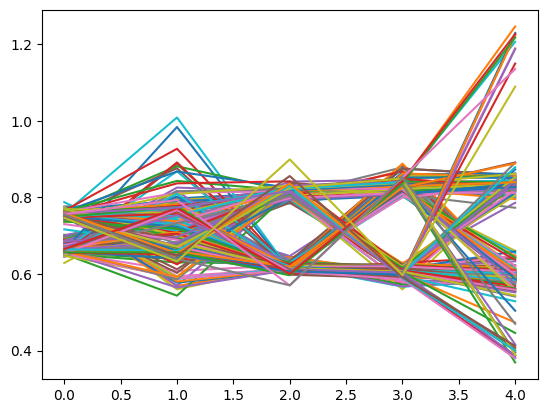

In [8]:

loader = DataLoader(graphs, batch_size=1, shuffle=True)


# Initialize model
model = GNN(
    input_channels=int(config["PARAMETERS"]["NInputFeatures"]),
    hidden_channels=128,
    output_channels=int(config["PARAMETERS"]["NClasses"]),
    dropout=0)

# Load state dict of saves model
try:
    model.load_state_dict(torch.load(config["PARAMETERS"]["ModelPath"]))
    print("Loading model...")
except FileNotFoundError:
    print("Creating new model...")

# Model parameters
train_epochs = int(config["PARAMETERS"]["NTrainEpochs"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)

# Run model
print("Starting training phase...")
loss_arr = run_model_for_graphs_list(
    model, loader, optimizer, train_epochs, len(graphs))

# Plot Loss curve
for i in range(len(graphs)):
    plt.plot(np.arange(train_epochs), loss_arr[i, :])
plt.show()

# Save model state
torch.save(model.state_dict(), config["PARAMETERS"]["ModelPath"])

